# Introduction
The goal of this notebook is to use data to understand the relationship that pressure and temperature play in engine failure.  The type of data you plan on using heavily influences the type of algorithm that's available to use.  Additionally, it's usually a good idea to visualize the data before making any decision about what kind of algorithm to use.

First, let's import the necessary modules and then read in the data.

## Imports

In [2]:
# For manipulating data
import pandas as pd
import numpy as np


# For plotting graphs
import matplotlib.pyplot as plt

# For constructing the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# For evaluating model performance
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read Data

In [3]:
# Load the data set.  Use the CSV's first column as the dataframe's index
df = pd.read_csv("https://raw.githubusercontent.com/papir805/Stanford-ML-Class/master/data/toy_data.csv", index_col=0)

# Check data loaded correctly
df.head()

,pressure (psi),temperature (deg F),failure
0,15.02,192.80,no
1,15.34,199.77,no
2,15.09,197.31,no
3,14.22,199.04,no
4,14.24,205.32,no


In [4]:
# Store label names for x and y
x1_label = 'pressure (psi)'
x2_label = 'temperature (deg F)'

# Store target label name
target_label = 'failure'

# Extract unique target labels
label_0 = 'no'
label_1 = 'yes'

## Visualize The dataset

In [5]:
# Assign colors based on target_label for visualization
df['color'] = df[target_label].map({label_0:'green', label_1:'red'})

# Seperate the data on engines that failed
# from those that didn't
df_yesses = df[df[target_label]==label_1]
df_nos = df[df[target_label]==label_0]

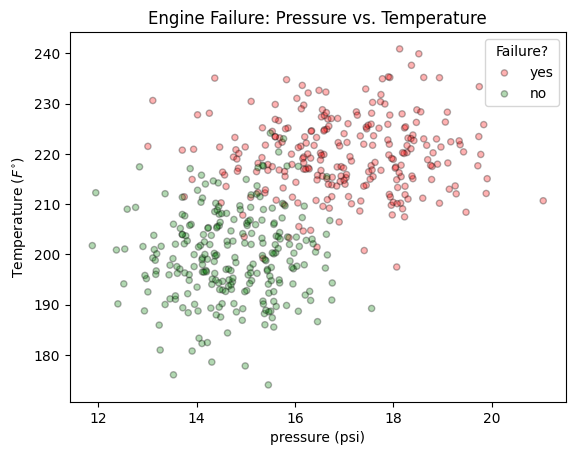

In [6]:
# Create figure and axis for graphing
fig, ax = plt.subplots(1,1)

# Scatter plot of engine data that failed
ax.scatter(x=df_yesses[x1_label],
           y=df_yesses[x2_label],
           c=df_yesses['color'],
           label=label_1, s=20,
           edgecolor="k", alpha=0.3)

# Scatter plot of engine data that didn't fail
ax.scatter(x=df_nos[x1_label],
           y=df_nos[x2_label],
           c=df_nos['color'],
           label=label_0, s=20,
           edgecolor="k", alpha=0.3)

ax.set_title('Engine Failure: Pressure vs. Temperature')
ax.set_xlabel(x1_label)
ax.set_ylabel(r'Temperature ($F^{\circ}$)')
ax.legend(title='Failure?')

plt.show()

It looks like higher pressure and/or higher temperature is when most engines in the dataset fail.  Using machine, it may be possible to understand the limits of these engines and what range of operating pressures or temperatures are best suited to keep them running.

# Why Logistic Regression

Regression is often a great statistical tool to help understand relationships between data, however, the type of regression one choses to use depends on several factors.  

Logistic regression is able to use any number of qualitative or quantitative inputs to predict a qualitative output.  **It can only predict a qualitative output**.  Because our goal is to predict whether an engine failed or not, which is qualitative, logistic regression can be used.

**Note**: Using qualitative inputs involves a little more effort than quantitative inputs, as does trying to predict a qualitative output that's non-binary.  This notebook will first consider the simplest case of logistic regression, when only quantitative inputs are used (engine pressure and temperature) and when the output is binary (the engine either failed or it didn't).  However, sections will be added to the notebook later to discuss how to deal with more complex situations.

# Generate Training and Testing Data

While not true in all circumstances, the goal of many ML algorithms is to use the algorithm on new and unseen data at some point.  For this reason, it's important to test the algorithm on unseen data in order to verify its performance and whether or not it will be worthwhile to use.  

This leaves two options:
* Option 1: Build the model now and wait for a sufficient amount of new data to come in, which can be used to verify the model's accuracy.
* Option 2: Parition the dataset into a training set and a testing set.  The training set can be used to build the model and the testing set will only be used to verify the accuracy.

Some may be concerned that by partioning your dataset and then only using part of it to build the model might negatively affect its performance.  After all, it's reasonable to think that the more data points you have the better off it will be, yet in truth there tend to be diminishing returns.  As it turns out, as long as your dataset is sufficiently large, performing a train/test split will still yield quite good results.  Given the alternative is waiting, a train/test split approach is preferred because it will allow you to determine performance immmediately and tweaks to the model can be implemented quickly, if need be.

In [7]:
# Separate feature names
feat_names = [x1_label, x2_label]

# Extract unique class labels
unique_labels = df[target_label].unique()

In [8]:
# Split dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(df[feat_names],
                                                    df[target_label],
                                                    test_size=0.25,
                                                    random_state=42)

# Training the Logistic Regression Model

In the case of using two inputs, $x_1$ and $x_2$, to predict the probability of a label of 1 (engine failure) $P$, the model is the sigmoid function:

$$P=\frac{1}{1+e^{-y}}$$


The exponent represents a linear model of the form:
$$y=\beta_2 \cdot x_2 + \beta_1 \cdot x_1 + \beta_0$$


And the final model looks like this:
$$P=\frac{1}{1+e^{-(\beta_2 \cdot x_2 + \beta_1 \cdot x_1 + \beta_0)}}$$

In [9]:
# Create logistic regression object
log_reg_classifier = LogisticRegression(random_state=0)

# Train the model using the training dataset
log_reg_classifier = log_reg_classifier.fit(X_train, y_train)

# The model's coefficients
beta_2 = log_reg_classifier.coef_[0][0]
beta_1 = log_reg_classifier.coef_[0][1]
print(f"Estimated beta_2: {beta_2:.4f}")
print(f"Estimated beta_1: {beta_1:.4f}")

# The model's intercept
beta_0 = log_reg_classifier.intercept_[0]
print(f"Estimated beta_0: {beta_0:.4f}")

Estimated beta_2: 1.4177
Estimated beta_1: 0.2736
Estimated beta_0: -79.8875


Based on the training data, the model will use the values from above and look like so:

$$P=\frac{1}{1+e^{-(1.4177\cdot x_2 + 0.2736\cdot x_1 -79.8875)}}$$

# Evaluating model performance - Testing Data

## Making Predictions

Now that the model has been trained, it can be used to make predictions.  Logistic regression works by taking all inputs to the model and calculating a probability of a binary output.  When the predicted probability is >50%, the model assigns the observations a label of 1 (engine failure) for that observation, otherwise it assigns the observation a label of 0 (engine didn't fail).

In [10]:
# Make predictions using the already seen training data
predictions = log_reg_classifier.predict(X_test)
probabilities = log_reg_classifier.predict_proba(X_test)

results_df = pd.DataFrame({x1_label:X_test[x1_label],
                           x2_label:X_test[x2_label],
                         #'prob of no':probabilities[:,0],
                         'prob of fail':probabilities[:,1],
                         'predicted failure':predictions,
                         'actual failure': y_test})
results_df.head()

,pressure (psi),temperature (deg F),prob of fail,predicted failure,actual failure
361,17.93,235.23,0.999950,yes,yes
73,14.03,188.73,0.000235,no,no
374,15.93,219.96,0.947080,yes,yes
155,14.94,204.14,0.054796,no,no
104,11.95,212.28,0.007696,no,no


Remembering the model from earlier, the results_df from above can be explained.  For the first entry, $\text{pressure} = 17.93$ and $\text{temperature} = 235.23$.  Plugging these values into $x_2$ and $x_1$ respectively will yield the model's probability of that observation being labeled 1 (failure).

$$P=\frac{1}{1+e^{-(1.4177(17.93) + 0.2736(235.23) -79.8875)}}$$
$$P=\frac{1}{1+e^{-9.890789}}$$
$$P=0.999950$$

The logistic regression model's probablility of failure based on pressure (psi) and temperature $(F^{\circ})$ is 0.999950.  That probability is >50% and therefore the observation is labeled as 1 (engine failed).  

For the second row, the predicted probability of failure is only 0.000235.  That probability is $\leq$50% and the observation is labeled as 0 (no failure).

All 5 entries in the results_df have the predicted failure value match the actual failure value, meaning all 5 predictions on these observations were correct, but how's the accuracy for the rest of the dataset?

## Checking Accuracy

Predicting a qualitative output is commonly referred to as a classification problem.  In this example, the goal is to classify an engine and either failing or not failing based on pressure and temperature.  The most common metric for evaluating performance is known as accuracy, which represents the percentage of predictions that were correct:

$$\text{accuracy}=\frac{n \text{ correct predictions}}{m \text{ total predictions}}$$

In [11]:
accuracy = log_reg_classifier.score(X_test, y_test)
accuracy

0.912

The model has high accuracy on testing data, correctly predicting when an engine will fail 91.2% of the time.  The model appears to do well on unseen data, giving confidence that it generalizes to new data well.

## Visualizing Decision Boundaries

The decision boundary represents the boundary between the algorithm predicting one label versus another.  Depending on what side of the boundary an observation is on, the algorithm will predict the label corresponding to that side.

In [12]:
# Create copy of X_test data
X_test_copy = X_test.copy(deep=True)

# Assign failure labels
X_test_copy[target_label] = y_test

# Assign colors
colors = []
for y in y_test:
    if y == 'yes':
        colors.append('red')
    else:
        colors.append('green')
X_test_copy['color'] = colors

# Separate failed engines from non-failed engines
test_yesses = X_test_copy[X_test_copy[target_label]=='yes']
test_nos = X_test_copy[X_test_copy[target_label]=='no']

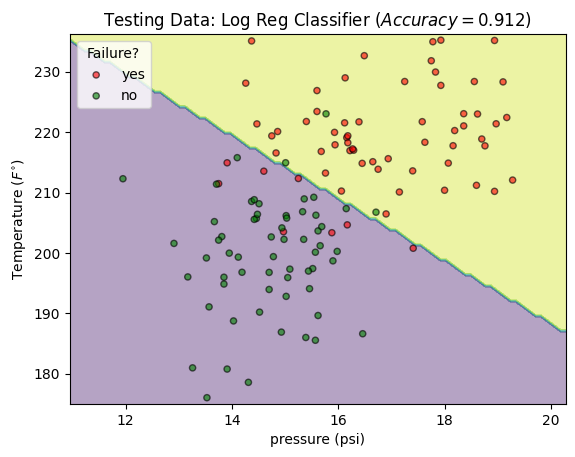

In [13]:
# Create figure and axis for graphing
fig, ax = plt.subplots(1,1)

# Draw the model's decision boundary, a boundary separating
# where it predicts a failure from a non-failure
DecisionBoundaryDisplay.from_estimator(estimator=log_reg_classifier,
                                       X=X_test,
                                       alpha=0.4,
                                       response_method="predict",
                                       ax=ax)

# Scatter plot of engine data that failed
ax.scatter(x=test_yesses[x1_label],
           y=test_yesses[x2_label],
           c=test_yesses['color'],
           s=20, edgecolor="k", label='yes', alpha=0.6)

# Scatter plot of engine data that didn't fail
ax.scatter(x=test_nos[x1_label],
           y=test_nos[x2_label],
           c=test_nos['color'],
           s=20, edgecolor="k", label='no', alpha=0.6)

ax.set_title(f'Testing Data: Log Reg Classifier $(Accuracy = {accuracy:.3f})$')
ax.set_ylabel(r'Temperature ($F^{\circ}$)')
ax.legend(title='Failure?')

#plt.tight_layout()
plt.show()

## Confusion Matrix

A confusion matrix helps get a slightly better picture of the model's predictive accuracy.  It enables one to see how many correct and incorrect predictions occurred.

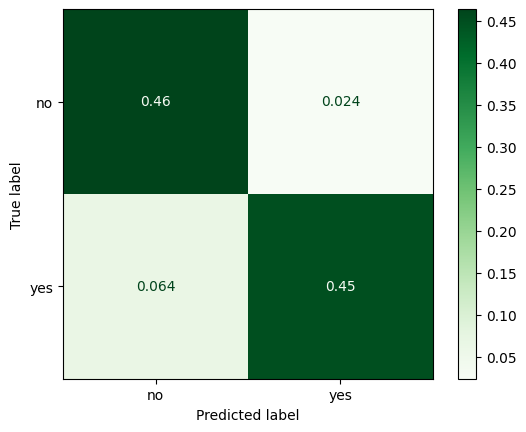

In [14]:
# Create confusion matrix object
cm = confusion_matrix(y_true=y_test,
                      y_pred=predictions,
                      labels=unique_labels,
                      normalize='all')

# Create confusion matrix display object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=unique_labels)

# Graph confusion matrix display
cm_display.plot(cmap='Greens')

plt.show()

The confusion matrix further breaks down the accuracy score shown early.  It shows the model correctly predicts engine failure 45% of the time and correctly predicts when an engine won't fail 46% of the time, giving a total of 91% accuracy.  Furthermore, the model incorrectly predicts when an engine won't fail 6.4% of the time and incorrectly predicts when an engine will fail 2.4% of the time.

# Conclusion

By visualizing the dataset, it was clear that some kind of relationship existing between the pressure and temperature of an engine and whether or not it would fail.  Logistic regression was able to pick up on this relationship and performed reasonably well on testing data, with an overall predictive accuracy of 91.2%.